# Evaluate siamese network and johnson-lindenstrauss for representation learning

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import multiprocessing as mp
import itertools
import plotly.express as px
from scipy.stats import entropy
from functools import partial
import re
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset, DataLoader
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Data

- See data.ipynb for data preparation

In [16]:
tensors_1kg = torch.load("1kg-g2g-tensors.pt")
targets_1kg = pd.read_csv("1kg-g2g_l2.tsv",sep="\t")
tensors_pcawg = torch.load("pcawg-g2g-tensors.pt")
targets_pcawg = pd.read_csv("pcawg-g2g_l2.tsv",sep="\t")
df_1kg = pd.read_csv("1kg-g2g_vecs.tsv",sep="\t", index_col=0)
df_pcawg = pd.read_csv("pcawg-g2g_vecs.tsv",sep="\t", index_col=0)
print(list(tensors_1kg.items())[0])
print(list(tensors_pcawg.items())[0])
print(targets_1kg.shape)
print(targets_pcawg.shape)
print(df_1kg.shape)
print(df_pcawg.shape)

('NA18614', tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32))
('FI26317', tensor([1., 6., 6.,  ..., 8., 2., 1.]))
(3211845, 3)
(10011, 3)
(2535, 18721)
(142, 18721)


In [17]:
df_1kg.head()

,ACYP2-AFF3,ACYP2-AGAP1,ACYP2-AP000304.12,ACYP2-APP,ACYP2-ARHGAP15,ACYP2-ARHGAP6,ACYP2-BACH1,ACYP2-CACNA2D3,ACYP2-CADM2,ACYP2-CCSER1,...,ZSWIM5-TTC28,ZSWIM5-ULK4,ZSWIM5-USH2A,ZSWIM5-VAV3,ZSWIM5-WDPCP,ZSWIM5-WWOX,ZSWIM5-ZBTB20,ZSWIM5-ZNF385D,ZSWIM5-ZNF536,ZSWIM5-ZRANB3
NA18614,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
HG01918,1,1,1,1,1,1,1,1,1,1,...,1,1,1,2,1,1,1,1,1,2
NA18546,1,1,1,1,1,1,2,1,1,1,...,1,1,1,1,1,1,1,1,1,1
HG02855,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,2,1
HG03565,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,2,1,1,1,1,1


In [18]:
df_pcawg.head()

,ACYP2-AFF3,ACYP2-AGAP1,ACYP2-AP000304.12,ACYP2-APP,ACYP2-ARHGAP15,ACYP2-ARHGAP6,ACYP2-BACH1,ACYP2-CACNA2D3,ACYP2-CADM2,ACYP2-CCSER1,...,ZSWIM5-TTC28,ZSWIM5-ULK4,ZSWIM5-USH2A,ZSWIM5-VAV3,ZSWIM5-WDPCP,ZSWIM5-WWOX,ZSWIM5-ZBTB20,ZSWIM5-ZNF385D,ZSWIM5-ZNF536,ZSWIM5-ZRANB3
FI26317,1,6,6,2,7,5,3,7,7,16,...,9,2,4,3,1,18,7,8,2,1
FI22889,10,12,5,12,2,7,3,5,3,16,...,5,2,9,3,8,5,1,9,2,1
FI45246,12,11,8,1,2,6,4,10,8,8,...,6,12,6,1,4,7,7,19,8,1
FI19114,7,9,10,10,6,4,6,33,17,14,...,11,11,6,7,5,10,10,7,9,5
FI45994,3,5,1,4,1,1,1,1,3,4,...,2,1,1,1,1,7,1,1,1,1


In [44]:
samples_1kg = df_1kg.index
sample_pairs_1kg = list(itertools.combinations(samples_1kg, 2))
print(len(sample_pairs_1kg))
sample_pairs_1kg[:5]

3211845


[('NA18614', 'HG01918'),
 ('NA18614', 'NA18546'),
 ('NA18614', 'HG02855'),
 ('NA18614', 'HG03565'),
 ('NA18614', 'NA19324')]

In [45]:
samples_pcawg = df_pcawg.index
sample_pairs_pcawg = list(itertools.combinations(samples_pcawg, 2))
print(len(sample_pairs_pcawg))
sample_pairs_pcawg[:5]

10011


[('FI26317', 'FI22889'),
 ('FI26317', 'FI45246'),
 ('FI26317', 'FI19114'),
 ('FI26317', 'FI45994'),
 ('FI26317', 'FI34411')]

In [47]:
sample_pairs_global = sample_pairs_1kg + sample_pairs_pcawg
print(len(sample_pairs_global))
sample_pairs_global[:5]

3221856


[('NA18614', 'HG01918'),
 ('NA18614', 'NA18546'),
 ('NA18614', 'HG02855'),
 ('NA18614', 'HG03565'),
 ('NA18614', 'NA19324')]

## Baseline: johnson-lindenstrauss

### Within population

In [2]:
np.random.seed(0)

#### 1kg

##### Epsilon = 0.1


In [37]:
# distortion threshold
epsilon = 0.1
# compute dimensionality
# such that the distortion is less than epsilon
n = 2500
k = int(np.ceil(4 * np.log(n) / ((epsilon**2) / ((2 - (epsilon**3)) / 3))))
k

2086

In [38]:
jl_1kg = GaussianRandomProjection(n_components=k, random_state=0)
df_1kg_jl = pd.DataFrame(jl_1kg.fit_transform(df_1kg))
print(df_1kg_jl.shape)
df_1kg_jl.index = df_1kg.index
df_1kg_jl.head()

(2535, 2086)


,0,1,2,3,4,5,6,7,8,9,...,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085
NA18614,-2.051126,-1.456229,1.092002,-2.992604,5.724252,6.829133,3.691685,6.263694,6.066922,-0.738450,...,0.272980,0.782090,3.451776,2.813435,1.412871,4.385370,3.945090,-1.796855,-3.564690,-0.671526
HG01918,-4.188421,-2.929395,1.031436,-3.002698,6.823088,4.705258,4.560896,7.202094,4.654009,-2.028744,...,0.236549,2.388977,1.831683,3.435842,1.664522,3.971462,2.639332,-2.005333,-2.661582,-0.368578
NA18546,-1.617051,-2.816215,-0.656346,-1.867814,6.993427,5.637329,4.379765,7.822922,4.497582,-0.964018,...,0.792185,3.809103,3.518849,3.948816,0.977811,5.082008,2.365027,-2.099849,-2.363069,-2.201466
HG02855,-3.507558,-2.334668,1.478754,-2.366508,5.864569,5.478177,4.399189,5.801723,3.456933,-0.583059,...,1.128956,1.588741,1.296292,2.986274,1.078364,4.191972,3.878989,-1.570710,-2.510935,-0.947581
HG03565,-2.866200,-2.596682,1.888015,-2.184448,6.031157,5.951043,4.294785,5.342199,4.487081,-1.275908,...,1.151451,1.673860,2.108185,3.293141,1.698277,3.719313,3.614750,-1.794606,-2.213681,-0.841359


In [39]:
# highlight 2 samples
samples2 = df_1kg.sample(2, random_state=0).index.tolist()
i1 = samples2[0]
i2 = samples2[1]
print(i1, i2)

HG03780 HG04054


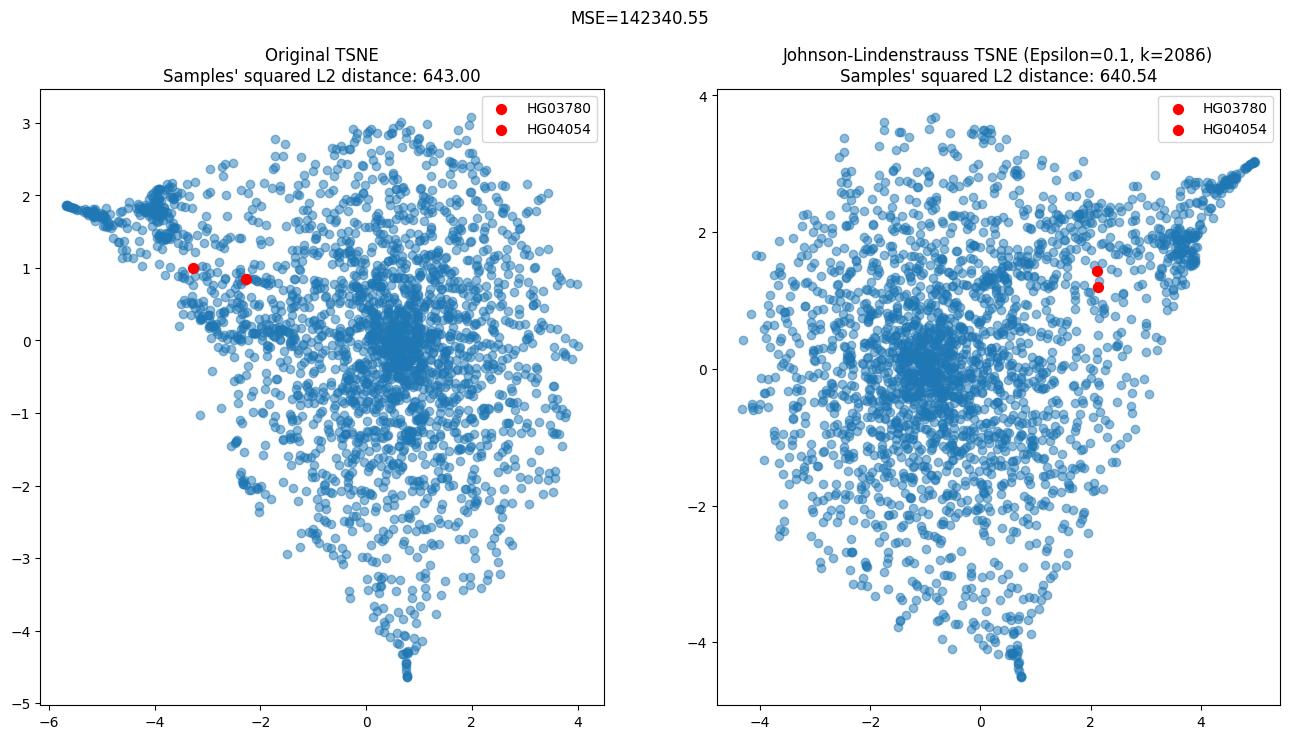

In [62]:
# # plot original and jl tsne

# fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# axes[0].scatter(df_tsne_original.iloc[:, 0], df_tsne_original.iloc[:, 1], alpha=0.5)
# axes[0].set_title("Original TSNE")
# axes[0].scatter(
#     df_tsne_original.loc[i1, 0],
#     df_tsne_original.loc[i1, 1],
#     color="red",
#     s=50,
#     label=i1,
# )
# axes[0].scatter(
#     df_tsne_original.loc[i2, 0],
#     df_tsne_original.loc[i2, 1],
#     color="purple",
#     s=50,
#     label=i2,
# )
# axes[0].legend()
# # axes[0].annotate('Point 1', (df_tsne_original.loc[i1, 0], df_tsne_original.loc[i1, 1]),
# #                  textcoords="offset points", xytext=(0,10), ha='center', color='red')
# # axes[0].annotate('Point 2', (df_tsne_original.loc[i2, 0], df_tsne_original.loc[i2, 1]),
# #                  textcoords="offset points", xytext=(0,10), ha='center', color='purple')

# axes[1].scatter(df_tsne_jl.iloc[:, 0], df_tsne_jl.iloc[:, 1], alpha=0.5)
# axes[1].set_title("Johnson-Lindenstrauss TSNE")
# axes[1].scatter(
#     df_tsne_jl.loc[i1, 0], df_tsne_jl.loc[i1, 1], color="red", s=50, label=i1
# )
# axes[1].scatter(
#     df_tsne_jl.loc[i2, 0], df_tsne_jl.loc[i2, 1], color="purple", s=50, label=i2
# )
# axes[1].legend()
# # axes[1].annotate('Point 1', (df_tsne_jl.loc[i1, 0], df_tsne_jl.loc[i1, 1]),
# #                  textcoords="offset points", xytext=(0,10), ha='center', color='red')
# # axes[1].annotate('Point 2', (df_tsne_jl.loc[i2, 0], df_tsne_jl.loc[i2, 1]),
# #                  textcoords="offset points", xytext=(0,10), ha='center', color='purple')

def tsne_contrastive(df1, df2,figtitle=None,  title1='tsne1', title2='tsne2', samples=None):
    # df 1
    tsne1 = TSNE(n_components=2, random_state=0)
    df_tsne1 = pd.DataFrame(tsne1.fit_transform(df1))
    df_tsne1.index = df1.index

    tsne2 = TSNE(n_components=2, random_state=0)
    df_tsne2 = pd.DataFrame(tsne2.fit_transform(df2))
    df_tsne2.index = df2.index

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    axes[0].scatter(df_tsne1.iloc[:, 0], df_tsne1.iloc[:, 1], alpha=0.5)
    axes[0].set_title(title1)
    if samples:
        for i in samples:
            axes[0].scatter(
                df_tsne1.loc[i, 0], df_tsne1.loc[i, 1], color="red", s=50, label=i
            )
        # squared l2 distance
        d = np.linalg.norm(df1.loc[samples[0]] - df1.loc[samples[1]]) ** 2
        axes[0].set_title(f"{title1}\nSamples' squared L2 distance: {d:.2f}")
    axes[0].legend()

    # df 2
    axes[1].scatter(df_tsne2.iloc[:, 0], df_tsne2.iloc[:, 1], alpha=0.5)
    axes[1].set_title(title2)
    if samples:
        for i in samples:
            axes[1].scatter(
                df_tsne2.loc[i, 0], df_tsne2.loc[i, 1], color="red", s=50, label=i
            )
        # squared l2 distance
        d = np.linalg.norm(df2.loc[samples[0]] - df2.loc[samples[1]]) ** 2
        axes[1].set_title(f"{title2}\nSamples' squared L2 distance: {d:.2f}")
    axes[1].legend()
    if figtitle:
        fig.suptitle(figtitle)
# note: rmse is computed below
tsne_contrastive(df_1kg, df_1kg_jl, figtitle=f'MSE={mse_jl_eps_01:.2f}', title1='Original TSNE', title2=f'Johnson-Lindenstrauss TSNE (Epsilon={epsilon}, k={k})', samples=(i1,i2))

MSE

In [49]:
def dist_sq_l2(sample_pair, df_vec):
    s1 = df_vec.loc[sample_pair[0], :]
    s2 = df_vec.loc[sample_pair[1], :]
    return sample_pair, np.linalg.norm(s1 - s2) ** 2

In [ ]:
# runtime: 6min 30s on 15 cores
# jl l2 squared distances
l2s_jl = []
for sp in sample_pairs_1kg:
    l2s_jl.append(dist_sq_l2(sp, df_1kg_jl))

In [56]:
path = "/home/jake/ghub/csci-7000-006-neurosymbolic-nlp/1kg-g2g_l2-jl_eps_01.tsv"
l2_jl_1kg_eps_01 = pd.DataFrame(l2s_jl, columns=["sample_pair", "l2"])
l2_jl_1kg_eps_01[["s_i", "s_j"]] = pd.DataFrame(
    l2_jl_1kg_eps_01["sample_pair"].tolist(), index=l2_jl_1kg_eps_01.index
)
l2_jl_1kg_eps_01.drop("sample_pair", axis=1, inplace=True)
l2_jl_1kg_eps_01.to_csv(
    path, sep="\t", index=False
)

In [57]:
l2_jl_1kg_eps_01.head()

,l2,s_i,s_j
0,2085.554820,NA18614,HG01918
1,3077.700080,NA18614,NA18546
2,1392.259277,NA18614,HG02855
3,1440.585380,NA18614,HG03565
4,1212.932743,NA18614,NA19324


In [59]:
 Extract the ground truth and predicted values
y_true = targets_1kg["l2"].values
y_pred = l2_jl_1kg_eps_01["l2"].values

# Compute the Mean Squared Error (MSE)
mse_jl_eps_01 = np.mean((y_true - y_pred) ** 2)

print(f"Mean Squared Error: {mse_jl_eps_01:.2f}")

Mean Squared Error: 142340.55


##### Epsilon = 0.05

In [34]:
# distortion threshold
epsilon = 0.05
# compute dimensionality
# such that the distortion is less than epsilon
n = 2500
k = int(np.ceil(4 * np.log(n) / ((epsilon**2) / ((2 - (epsilon**3)) / 3))))
k

8346

In [35]:
jl_1kg = GaussianRandomProjection(n_components=k, random_state=0)
df_1kg_jl = pd.DataFrame(jl_1kg.fit_transform(df_1kg))
print(df_1kg_jl.shape)
df_1kg_jl.index = df_1kg.index
df_1kg_jl.head()

(2535, 8346)


,0,1,2,3,4,5,6,7,8,9,...,8336,8337,8338,8339,8340,8341,8342,8343,8344,8345
NA18614,-1.025440,-0.728027,0.545936,-1.496123,2.861783,3.414157,1.845622,3.131472,3.033098,-0.369181,...,-1.635071,1.223963,-0.595971,-0.056969,-2.027429,-0.639990,-2.978909,1.882458,2.238071,-0.215450
HG01918,-2.093960,-1.464522,0.515656,-1.501169,3.411135,2.352347,2.280175,3.600616,2.326726,-1.014250,...,-1.051927,1.456325,0.345446,0.659130,-1.802837,-0.998883,-2.960917,1.615550,1.841080,-0.453684
NA18546,-0.808429,-1.407939,-0.328134,-0.933795,3.496295,2.818327,2.189620,3.910992,2.248522,-0.481951,...,-1.712473,1.457106,0.205576,0.590039,-1.667915,-1.018123,-3.333114,1.880983,2.245409,-1.040574
HG02855,-1.753569,-1.167194,0.739288,-1.183112,2.931933,2.738760,2.199331,2.900514,1.728260,-0.291495,...,-1.019134,1.043395,0.068507,0.573139,-2.300647,-1.152485,-1.995772,1.904557,1.577608,-0.908192
HG03565,-1.432928,-1.298186,0.943894,-1.092093,3.015217,2.975165,2.147135,2.670779,2.243272,-0.637878,...,-1.145276,1.114458,0.237670,0.446908,-2.199421,-1.238291,-2.308198,1.696419,1.618725,-0.514636


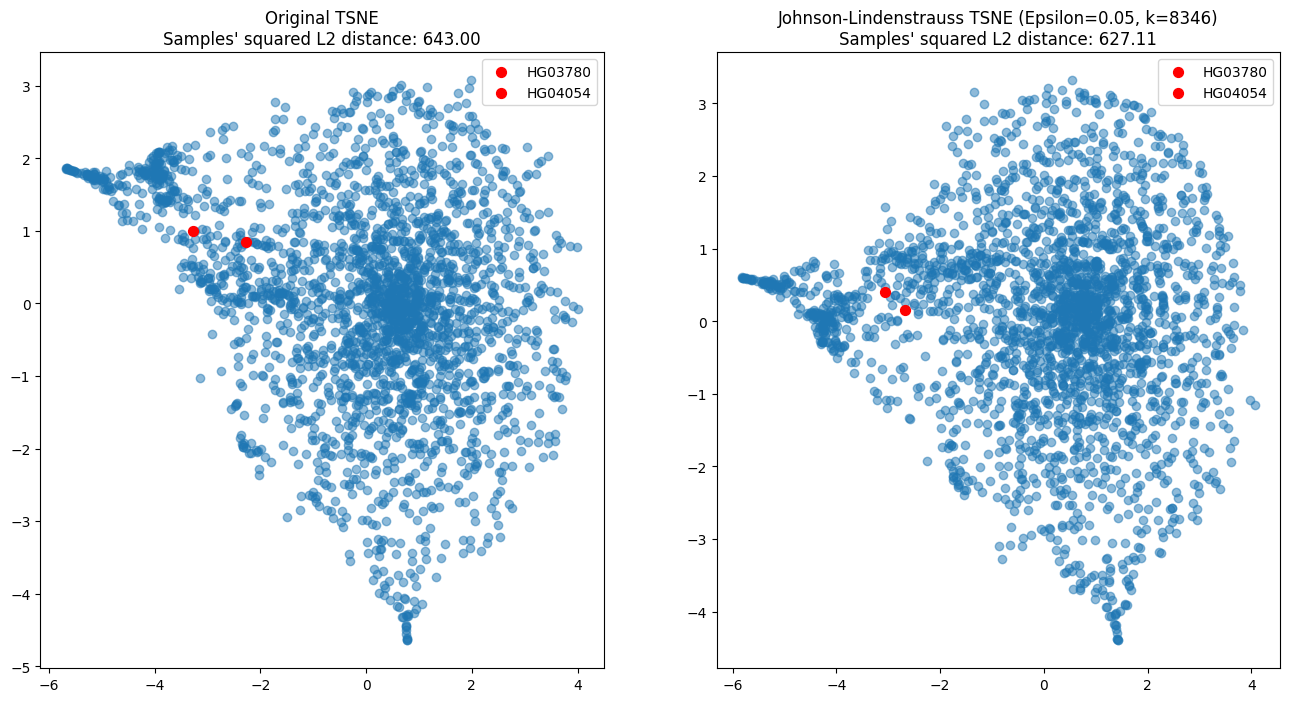

In [36]:
# contrastive tsne
tsne_contrastive(df_1kg, df_1kg_jl, title1='Original TSNE', title2=f'Johnson-Lindenstrauss TSNE (Epsilon={epsilon}, k={k})', samples=(i1,i2))

In [ ]:
l2s_jl = []
i = 0
for sp in sample_pairs:
    i = i + 1
    l2s_jl.append(dist_sq_l2(sp, df_vec_transformed))

In [ ]:
df_l2s_jl_1kg = pd.DataFrame(l2s_jl, columns=["sample_pair", "l2"])
df_l2s_jl_1kg[["s_i", "s_j"]] = pd.DataFrame(
    df_l2s_jl_1kg["sample_pair"].tolist(), index=df_l2s_jl_1kg.index
)
df_l2s_jl_1kg.drop("sample_pair", axis=1, inplace=True)
df_l2s_jl_1kg.to_csv(
    "/data/jake/csci_7000-final_project/1kg-g2g_l2-jl.tsv", sep="\t", index=False
)

In [ ]:
df_l2s_jl_1kg["l2"].hist(bins=100)

In [ ]:
df_l2s_jl_1kg["l2_log10"] = df_l2s_jl_1kg["l2"].apply(lambda x: np.log10(x + 1))
sc = StandardScaler()
df_l2s_jl_1kg["l2_log10_z"] = sc.fit_transform(
    df_l2s_jl_1kg["l2_log10"].to_numpy().reshape(-1, 1)
)
df_l2s_jl_1kg.head()

In [ ]:
df_l2s_jl_1kg["l2_log10_z"].hist(bins=100)

In [ ]:
# mse between original and jl transformed l2 distances
np.mean((df_l2s_1kg["l2_log10_z"] - df_l2s_jl_1kg["l2_log10_z"]) ** 2)